In [48]:
# Importando as bibliotecas necessárias
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [49]:
# Função para dividir o dataframe em conjuntos de treino e teste
def divide_dados(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    return train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# Função para equilibrar o dataframe em relação à coluna alvo
def equilibra_dataframe(df, coluna_target, proporcao=1.0):

    # Separando as classes majoritária e minoritária
    maioria = df[df[coluna_target] == 0]
    minoria = df[df[coluna_target] == 1]

    # Reduzindo a classe majoritária ao tamanho da classe minoritária
    tamanho_amostra = int(proporcao * len(minoria))
    maioria_reduzida = maioria.sample(n=tamanho_amostra, random_state=42)

    # Concatenando as duas classes e embaralhando
    df_equilibrado = pd.concat([maioria_reduzida, minoria])
    df_equilibrado = df_equilibrado.sample(frac=1, random_state=42) # embaralha os dados

    return df_equilibrado

In [51]:
# Função para treinar e avaliar um modelo genérico
def avalia_modelo_generico(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Para modelos que não têm o método "predict_proba", como o SVC sem a opção "probability=True"
        y_proba = model.decision_function(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)
    
    metrics = {
        "Accuracy": accuracy,
        "F1-Score": f1,
        "Precision": precision,
        "Recall": recall,
        "AUC-ROC": auc_roc
    }
    
    return metrics

### Carregando o arquivo em um DataFrame

In [52]:
# Definindo o diretório de trabalho
os.chdir(r'C:\Users\Felipe\OneDrive - AGU\Certificados - cursos\Cursos - arquivos\PUC Minas\TCC\Base de dados - TSE candidatos')
# Lendo o dataframe a partir de um arquivo parquet
df = pd.read_parquet('df_machine_learning.parquet')

In [53]:
# Convertendo colunas categóricas em colunas dummies (codificação one-hot)
df_codificado = pd.get_dummies(df)

In [54]:
# Equilibrando o dataframe
df_codificado_equilibrado = equilibra_dataframe(df_codificado, 'DEVEDOR')

In [55]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = divide_dados(df_codificado_equilibrado, 'DEVEDOR')

In [56]:
print(X_train.shape, '|', y_train.shape, '|',X_test.shape, '|', y_test.shape)

(8183, 378) | (8183,) | (3507, 378) | (3507,)


In [57]:
# Treinando e avaliando os modelos com a proporção 1
modelos = {
    "KNeighbors": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "SVC": SVC(probability=True),
    "RandomForest": RandomForestClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier()
}

resultados = {}
for nome, modelo in modelos.items():
    resultados[nome] = avalia_modelo_generico(modelo, X_train, X_test, y_train, y_test)

df_resultados = pd.DataFrame(resultados).T
print(df_resultados)

              Accuracy  F1-Score  Precision    Recall   AUC-ROC
KNeighbors    0.714001  0.712854   0.720486  0.705382  0.778626
GaussianNB    0.606501  0.690305   0.571535  0.871388  0.716064
DecisionTree  0.709153  0.710720   0.711528  0.709915  0.709985
SVC           0.763616  0.765885   0.763514  0.768272  0.835647
RandomForest  0.765326  0.768234   0.763718  0.772805  0.839005
MLP           0.711149  0.709825   0.717845  0.701983  0.781633
XGBoost       0.764186  0.767501   0.761719  0.773371  0.838753


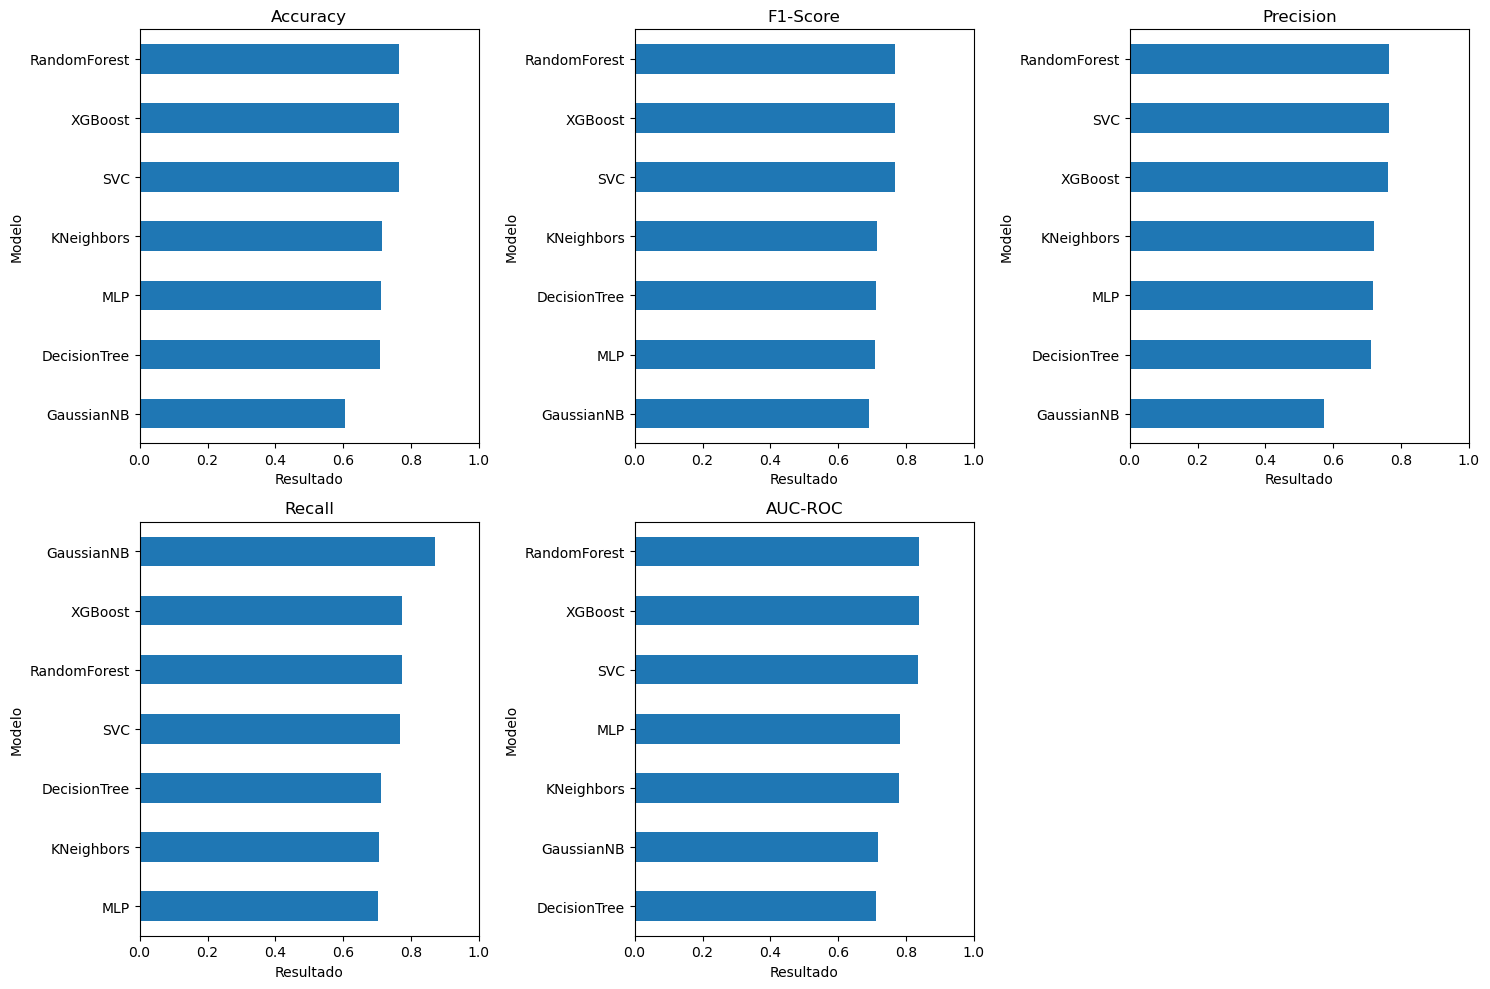

In [58]:
# Plotando os resultados em gráficos
plt.figure(figsize=(15, 10))

# Criando subplots para cada métrica
for idx, metric in enumerate(df_resultados.columns, 1):
    plt.subplot(2, 3, idx)
    df_resultados[metric].sort_values().plot(kind='barh', title=metric)
    plt.xlabel('Resultado')
    plt.ylabel('Modelo')
    plt.xlim(0, 1)

plt.tight_layout()
plt.show()

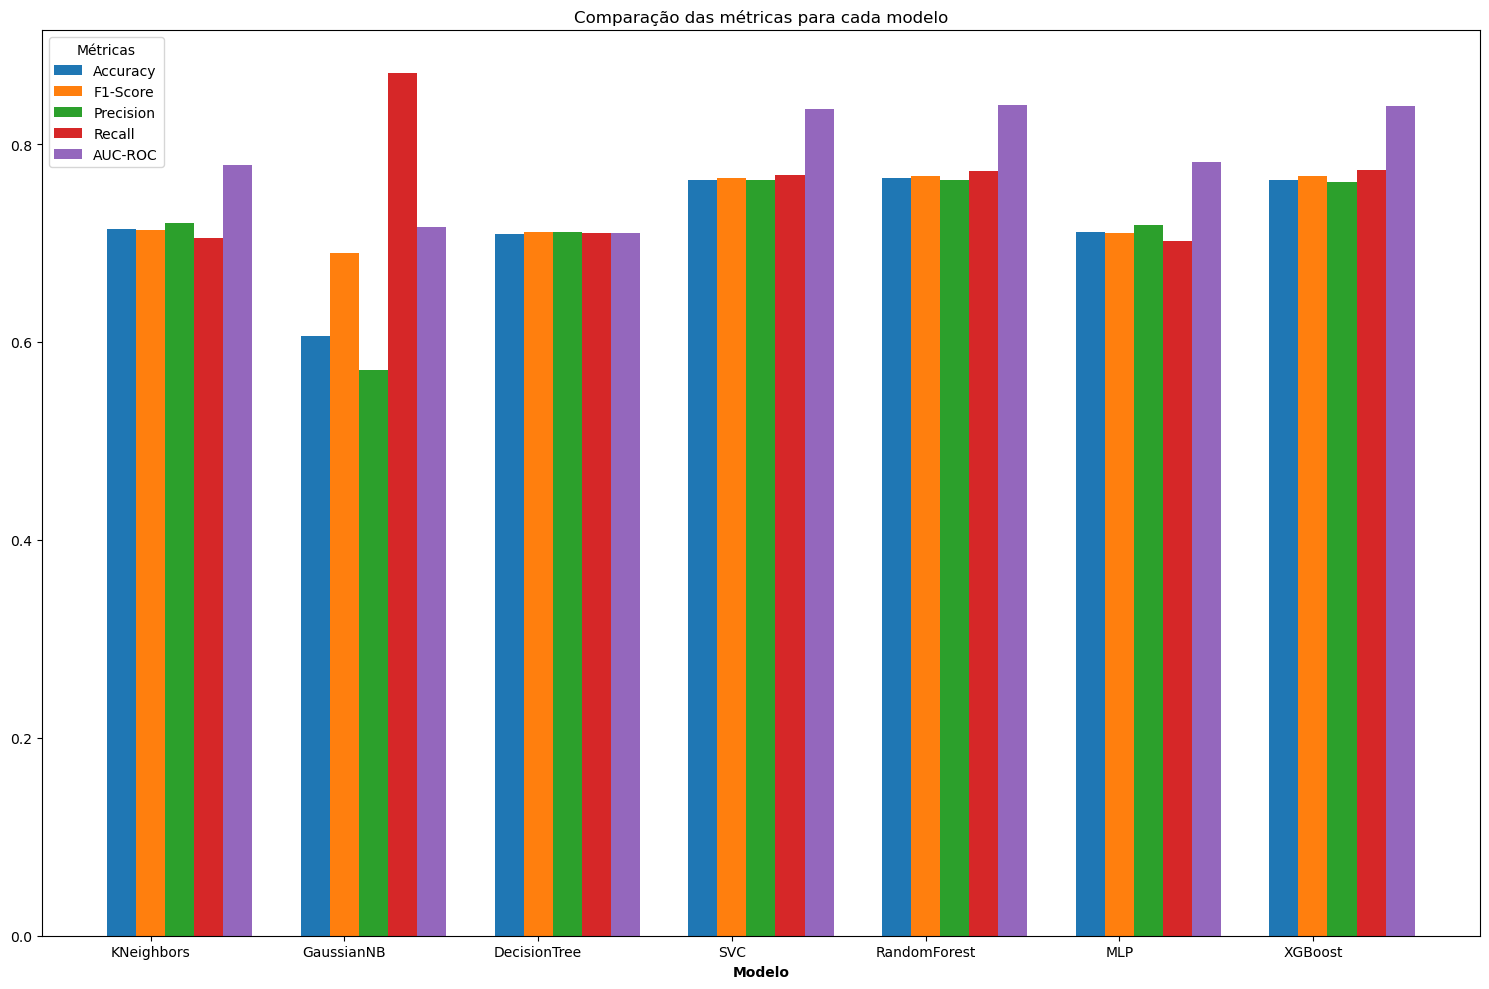

In [59]:
# Definindo o tamanho da figura
plt.figure(figsize=(15, 10))

# Número de modelos
num_models = len(df_resultados.index)

# Largura das barras
bar_width = 0.15

# Posições das barras
r = list(range(num_models))

# Plotando cada métrica em um conjunto de barras
for idx, metric in enumerate(df_resultados.columns):
    plt.bar([x + bar_width * idx for x in r], df_resultados[metric], width=bar_width, label=metric)

# Definindo eixo x
plt.xlabel('Modelo', fontweight='bold')
plt.xticks([r + bar_width for r in range(num_models)], df_resultados.index)

# Definindo legenda e título
plt.legend(title="Métricas")
plt.title('Comparação das métricas para cada modelo')

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [60]:
# Definindo os modelos
modelos = {
    "KNeighbors": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "SVC": SVC(probability=True),
    "RandomForest": RandomForestClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier()
}

# Avaliando o impacto de diferentes proporções de balanceamento
proporcoes = [1.5, 2, 3, 4]
lista_dfs = []

for proporcao in proporcoes:
    # Equilibrando o dataframe de acordo com a proporção
    df_equilibrado = equilibra_dataframe(df_codificado, 'DEVEDOR', proporcao)
    
    # Dividindo o dataframe equilibrado em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = divide_dados(df_equilibrado, 'DEVEDOR')
    
    # Avaliando modelos para o dataframe equilibrado
    print(f"Avaliando modelos para proporção: {proporcao}")
    resultados = {}
    for nome, modelo in modelos.items():
        resultados[nome] = avalia_modelo_generico(modelo, X_train, X_test, y_train, y_test)

    # Convertendo o dicionário de resultados em um DataFrame
    df_proporcao = pd.DataFrame(resultados).T
    df_proporcao['Proporção'] = proporcao
    lista_dfs.append(df_proporcao)
    print("--------------------------------------------------------------------")

# Concatenando todos os DataFrames
df_resultados_final = pd.concat(lista_dfs).set_index('Proporção', append=True)
print(df_resultados_final)

Avaliando modelos para proporção: 1.5
--------------------------------------------------------------------
Avaliando modelos para proporção: 2
--------------------------------------------------------------------
Avaliando modelos para proporção: 3
--------------------------------------------------------------------
Avaliando modelos para proporção: 4
--------------------------------------------------------------------
                        Accuracy  F1-Score  Precision    Recall   AUC-ROC
             Proporção                                                   
KNeighbors   1.5        0.725365  0.647128   0.673171  0.623025  0.775318
GaussianNB   1.5        0.440465  0.581471   0.416728  0.961625  0.529157
DecisionTree 1.5        0.726734  0.660045   0.663813  0.656321  0.715935
SVC          1.5        0.764142  0.689489   0.736842  0.647856  0.831676
RandomForest 1.5        0.765511  0.694774   0.733083  0.660271  0.835932
MLP          1.5        0.713960  0.646561   0.645833  0.647